In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import catboost as cb
print("cb.__version__:", cb.__version__)

from sklearn.model_selection import StratifiedGroupKFold

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

cb.__version__: 1.2.7


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

,Id,GameRulesetName,agent1,agent2,Properties,Format,Time,Discrete,Realtime,Turns,...,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond,EnglishRules,LudRules,num_wins_agent1,num_draws_agent1,num_losses_agent1,utility_agent1
0,0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",4,0,11,-0.466667
1,1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
2,2,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.1-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",7,0,8,-0.066667
3,3,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.6-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
4,4,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,233229,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-NST-false,MCTS-ProgressiveHistory-1.41421356237-Random20...,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",2,0,13,-0.733333
233230,233230,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1-0.6-MAST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",9,1,5,0.266667
233231,233231,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",11,3,1,0.666667
233232,233232,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-true,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",24,2,4,0.666667


In [3]:
# Load the feature selection results
with open('../feat_selection/select_optuna_lgbm.json', 'r') as f:
    feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', [])
categorical_cols = feature_selection.get('categorical', [])

print("Numerical features:", len(numerical_cols))
print("Categorical features:", len(categorical_cols))

Numerical features: 296
Categorical features: 5


In [4]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0
number of constant cols:  0
Numerical Columns: 370
Categorical Columns: 5


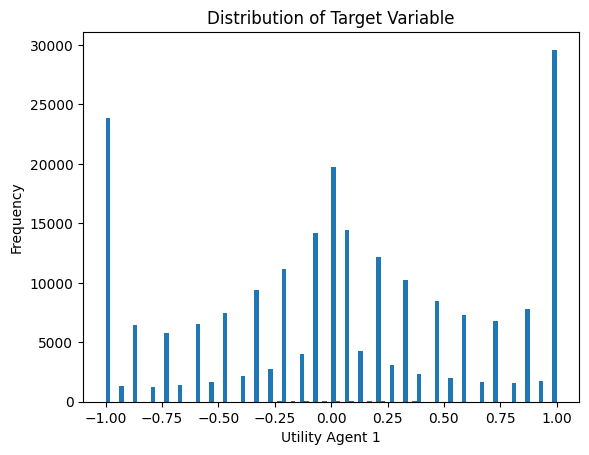

In [5]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

***
### train model

In [6]:
def get_feature_importance(model, importance_type='PredictionValuesChange'):
    """
    Get feature importance from a trained CatBoost model
    
    Args:
        model: Trained CatBoost model
        importance_type: Type of feature importance to calculate
            Options: 'PredictionValuesChange', 'LossFunctionChange', 
            'ShapValues', 'Interaction', 'TopKitty'
        
    Returns:
        pandas.DataFrame: DataFrame containing feature names and their importance scores
    """
    # Get feature importance scores
    importance_scores = model.get_feature_importance(type=importance_type)
    feature_names = model.feature_names_
    
    # Create dataframe with feature names and importance scores
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance_scores
    }).sort_values('importance', ascending=False, ignore_index=True)
    
    return importance_df


def plot_feature_importance(importance_df, top_n=100):
    plot_df = importance_df.head(top_n)
    
    plt.figure(figsize=(15, 5))
    plt.bar(x=range(len(plot_df)), height=plot_df['importance'])
    plt.xticks(range(len(plot_df)), plot_df['feature'], rotation=45, ha='right', fontsize=8)
    plt.ylabel('Importance Score')
    plt.title(f'Top {top_n} Most Important Features')
    plt.tight_layout()
    plt.show()

/Users/mavillan/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-E8z0EJ47-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:994: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fold 1
0:	learn: 0.6031670	test: 0.6061369	best: 0.6061369 (0)	total: 233ms	remaining: 11m 39s
50:	learn: 0.3951894	test: 0.4579505	best: 0.4579505 (50)	total: 9.05s	remaining: 8m 43s
100:	learn: 0.3576454	test: 0.4403934	best: 0.4403934 (100)	total: 17.8s	remaining: 8m 30s
150:	learn: 0.3383005	test: 0.4349419	best: 0.4349419 (150)	total: 26.5s	remaining: 8m 20s
200:	learn: 0.3246749	test: 0.4311634	best: 0.4311634 (200)	total: 35.8s	remaining: 8m 18s
250:	learn: 0.3143761	test: 0.4282615	best: 0.4282564 (249)	total: 45.6s	remaining: 8m 19s
300:	learn: 0.3046622	test: 0.4256680	best: 0.4256680 (300)	total: 56.5s	remaining: 8m 26s
350:	learn: 0.2972077	test: 0.4241280	best: 0.4241191 (349)	total: 1m 5s	remaining: 8m 14s
400:	learn: 0.2909941	test: 0.4229862	best: 0.4229862 (400)	total: 1m 16s	remaining: 8m 13s
450:	learn: 0.2853863	test: 0.4221412	best: 0.4221396 (448)	total: 1m 25s	remaining: 8m 2s
500:	learn: 0.2805735	test: 0.4215185	best: 0.4215185 (500)	total: 1m 34s	remaining: 7m

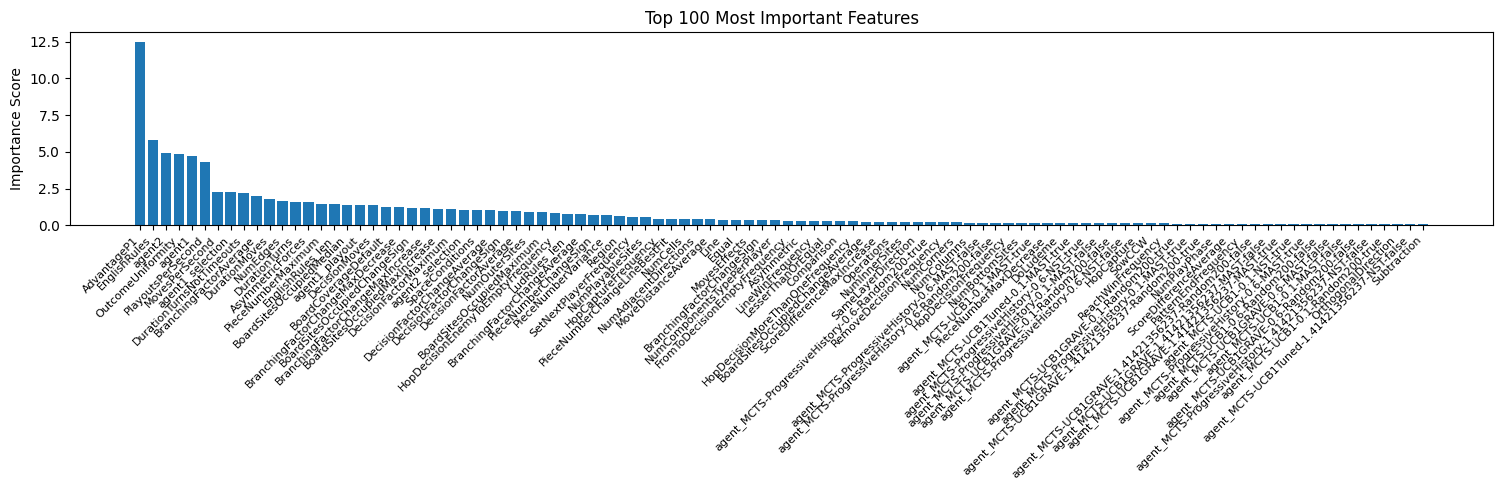

Fold 1 - RMSE: 0.41473326539486993
Fold 2
0:	learn: 0.5973423	test: 0.6177799	best: 0.6177799 (0)	total: 214ms	remaining: 10m 43s
50:	learn: 0.3879470	test: 0.4881852	best: 0.4881852 (50)	total: 9.42s	remaining: 9m 4s
100:	learn: 0.3550341	test: 0.4715357	best: 0.4715357 (100)	total: 19.1s	remaining: 9m 8s
150:	learn: 0.3346417	test: 0.4663271	best: 0.4663194 (148)	total: 28s	remaining: 8m 47s
200:	learn: 0.3214109	test: 0.4627214	best: 0.4627214 (200)	total: 36.8s	remaining: 8m 32s
250:	learn: 0.3114166	test: 0.4599105	best: 0.4598984 (247)	total: 45.9s	remaining: 8m 22s
300:	learn: 0.3037281	test: 0.4580643	best: 0.4580643 (300)	total: 54.7s	remaining: 8m 10s
350:	learn: 0.2964346	test: 0.4569082	best: 0.4569082 (350)	total: 1m 4s	remaining: 8m 4s
400:	learn: 0.2902506	test: 0.4555981	best: 0.4555917 (399)	total: 1m 14s	remaining: 7m 59s
450:	learn: 0.2849702	test: 0.4547281	best: 0.4547184 (449)	total: 1m 23s	remaining: 7m 50s
500:	learn: 0.2800384	test: 0.4538294	best: 0.4538294 (5

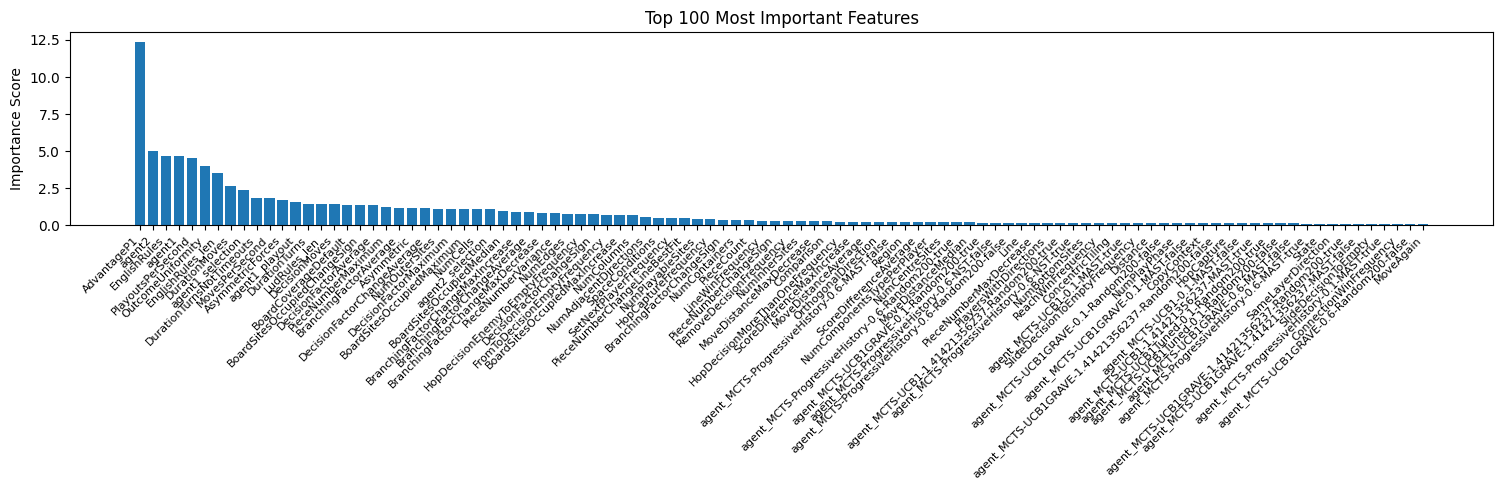

Fold 2 - RMSE: 0.44566877562410306
Fold 3
0:	learn: 0.6053167	test: 0.5845743	best: 0.5845743 (0)	total: 181ms	remaining: 9m 1s
50:	learn: 0.3960950	test: 0.4523308	best: 0.4523308 (50)	total: 9.24s	remaining: 8m 54s
100:	learn: 0.3595551	test: 0.4366121	best: 0.4366121 (100)	total: 17.9s	remaining: 8m 35s
150:	learn: 0.3385998	test: 0.4284009	best: 0.4284009 (150)	total: 27.1s	remaining: 8m 30s
200:	learn: 0.3247798	test: 0.4238083	best: 0.4238068 (199)	total: 36.6s	remaining: 8m 30s
250:	learn: 0.3139700	test: 0.4207667	best: 0.4207667 (250)	total: 45.9s	remaining: 8m 22s
300:	learn: 0.3051107	test: 0.4187471	best: 0.4187471 (300)	total: 54.6s	remaining: 8m 9s
350:	learn: 0.2975645	test: 0.4169191	best: 0.4169186 (349)	total: 1m 3s	remaining: 7m 57s
400:	learn: 0.2911551	test: 0.4153706	best: 0.4153706 (400)	total: 1m 12s	remaining: 7m 47s
450:	learn: 0.2856717	test: 0.4144863	best: 0.4144863 (450)	total: 1m 21s	remaining: 7m 39s
500:	learn: 0.2805843	test: 0.4139406	best: 0.4139190 

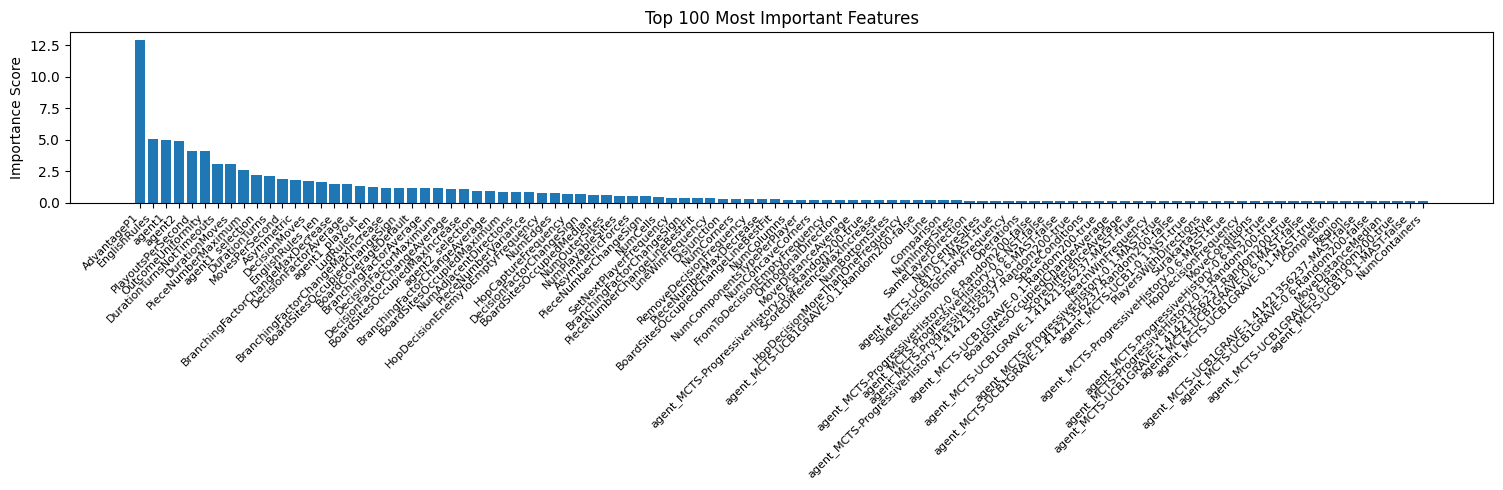

Fold 3 - RMSE: 0.40696498251537655
Fold 4
0:	learn: 0.5985350	test: 0.6159502	best: 0.6159502 (0)	total: 198ms	remaining: 9m 54s
50:	learn: 0.3943974	test: 0.4673547	best: 0.4673547 (50)	total: 9.05s	remaining: 8m 43s
100:	learn: 0.3602565	test: 0.4514562	best: 0.4514562 (100)	total: 17.6s	remaining: 8m 25s
150:	learn: 0.3376179	test: 0.4414425	best: 0.4414425 (150)	total: 26.2s	remaining: 8m 13s
200:	learn: 0.3234070	test: 0.4367515	best: 0.4367515 (200)	total: 34.9s	remaining: 8m 6s
250:	learn: 0.3122804	test: 0.4341161	best: 0.4341161 (250)	total: 43.5s	remaining: 7m 56s
300:	learn: 0.3038592	test: 0.4314431	best: 0.4314431 (300)	total: 52.2s	remaining: 7m 48s
350:	learn: 0.2964433	test: 0.4294818	best: 0.4294818 (350)	total: 1m 1s	remaining: 7m 46s
400:	learn: 0.2904926	test: 0.4282469	best: 0.4282458 (399)	total: 1m 11s	remaining: 7m 43s
450:	learn: 0.2847434	test: 0.4271346	best: 0.4271346 (450)	total: 1m 20s	remaining: 7m 35s
500:	learn: 0.2792033	test: 0.4260665	best: 0.4260407

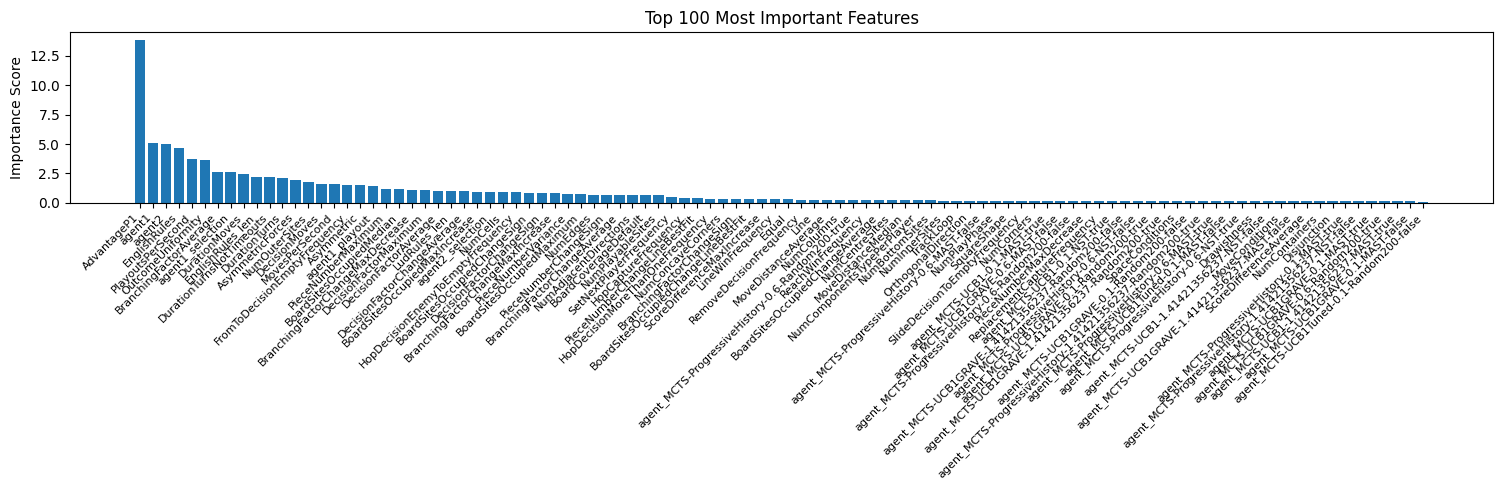

Fold 4 - RMSE: 0.4150753893808156
Fold 5
0:	learn: 0.6005276	test: 0.6135138	best: 0.6135138 (0)	total: 184ms	remaining: 9m 12s
50:	learn: 0.3974008	test: 0.4797655	best: 0.4797655 (50)	total: 8.91s	remaining: 8m 35s
100:	learn: 0.3607159	test: 0.4641541	best: 0.4641541 (100)	total: 18.1s	remaining: 8m 40s
150:	learn: 0.3404053	test: 0.4594548	best: 0.4594548 (150)	total: 27.4s	remaining: 8m 37s
200:	learn: 0.3260207	test: 0.4553820	best: 0.4553820 (200)	total: 36.2s	remaining: 8m 23s
250:	learn: 0.3154445	test: 0.4525185	best: 0.4525185 (250)	total: 45s	remaining: 8m 12s
300:	learn: 0.3065684	test: 0.4500609	best: 0.4500609 (300)	total: 54.1s	remaining: 8m 4s
350:	learn: 0.2994347	test: 0.4486278	best: 0.4485551 (346)	total: 1m 3s	remaining: 7m 58s
400:	learn: 0.2929882	test: 0.4473273	best: 0.4473180 (398)	total: 1m 13s	remaining: 7m 55s
450:	learn: 0.2875460	test: 0.4460357	best: 0.4460307 (449)	total: 1m 22s	remaining: 7m 47s
500:	learn: 0.2821654	test: 0.4447349	best: 0.4447349 (5

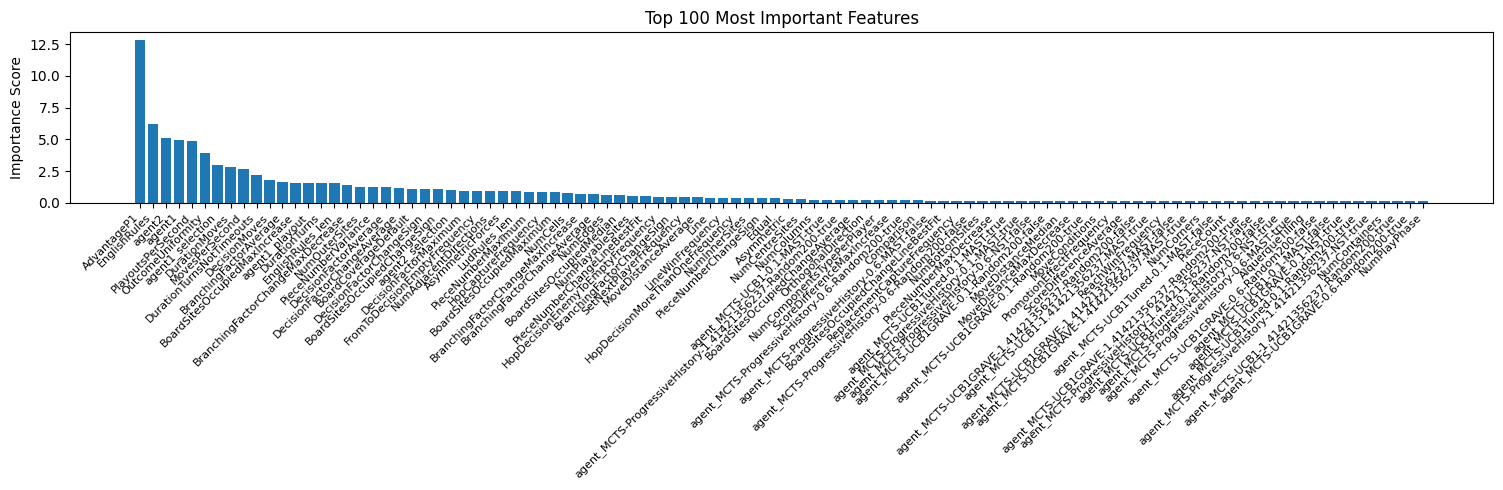

Fold 5 - RMSE: 0.43715076627836974
List of oof scores: [0.41473326539486993, 0.44566877562410306, 0.40696498251537655, 0.4150753893808156, 0.43715076627836974]
Average oof score: 0.4239186358387069


In [7]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        text_cols,
        target='utility_agent1',
        num_folds=5,
    ):
    # Define the number of folds for cross-validation
    group_col = "GameRulesetName"
    y_col = "utility_agent1_rank"
    gkf = StratifiedGroupKFold(n_splits=num_folds, random_state=2112, shuffle=True)
    split_list = gkf.split(df_train, groups=df_train[group_col], y=df_train[y_col])

    # Define the parameters for CatBoost
    params = {
        'objective': "RMSE",
        'learning_rate': 0.1,
        'depth': 10,
        'iterations': 3000,
        'eval_metric': 'RMSE',
        'verbose': 0,
        'random_seed': 2112,
        'l2_leaf_reg': 1.,
        'random_strength': 0.2,
        'min_data_in_leaf': 50,
        'rsm': 0.8,
        # 'text_processing': {
        #     'tokenizers': [{
        #         'tokenizer_id': 'Space',  # or 'GPT', 'Bert', etc.
        #         'separator_type': 'Space'
        #     }],
        #     'dictionaries': [{
        #         'dictionary_id': 'BiGram',
        #         'max_dictionary_size': '50000',
        #         'occurrence_lower_bound': '3',
        #         'gram_order': '2'
        #     }],
        #     'feature_calcers': [{
        #         'calcer_type': 'BoW',  # or 'NaiveBayes', 'BM25'
        #         'dictionary_id': 'BiGram'
        #     }]
        # }

        # Text processing parameters to mimic TF-IDF
        'tokenizers': [{
            'tokenizer_id': 'Space',
            'separator_type': 'ByDelimiter',
            'delimiter': ' '
        }],
        'dictionaries': [{
            'dictionary_id': 'NgramDict',
            'max_dictionary_size': '500',  # Match max_features=500
            'occurrence_lower_bound': '3',
            'gram_order': '3',  # Maximum n-gram size
            'min_gram_order': '2'  # Minimum n-gram size
        }],
        'feature_calcers': [{
            'calcer_type': 'BoW',  # Most similar to TF-IDF
            'dictionary_id': 'NgramDict'
        }],


        # 'tokenizers': [{
        #     'tokenizer_id': 'Space',
        #     'delimiter': ' ',
        #     'separator_type': 'ByDelimiter'
        # }],
        # 'dictionaries': [{
        #     'dictionary_id': 'Word',
        #     'max_dictionary_size': '50000',
        #     'occurrence_lower_bound': '3'
        # }],
        # 'feature_calcers': [{
        #     'calcer_type': 'BoW',
        #     'dictionary_id': 'Word',
        # }]
    }
    # Obtained with optuna
    # params = {
    #     'objective': 'RMSE',
    #     'verbose': False,
    #     'random_seed': 2112,
    #     'learning_rate': 0.1,
    #     'iterations': 3000,
    #     'bootstrap_type': 'Bayesian',
    #     'sampling_frequency': 'PerTreeLevel',
    #     'depth': 10,
    #     'l2_leaf_reg': 0.9359292512255313,
    #     'random_strength': 0.16693257025108216,
    #     'bagging_temperature': 0.15967219011745193,
    #     'rsm': 0.548125395769786,
    #     'min_data_in_leaf': 102,
    #     'max_ctr_complexity': 10
    # }

    trained_models = []
    oof = pd.DataFrame(index=df_train.index, columns=[f'{target}_true', f'{target}_pred'])
    oof_scores = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_valid = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_valid = X_train[target], X_valid[target]

        # Initialize CatBoost Pool
        train_pool = cb.Pool(
            data=X_train[numerical_cols + categorical_cols + text_cols],
            label=y_train,
            cat_features=categorical_cols,
            text_features=text_cols
        )
        val_pool = cb.Pool(
            data=X_valid[numerical_cols + categorical_cols + text_cols],
            label=y_valid,
            cat_features=categorical_cols,
            text_features=text_cols
        )
        
        # Initialize CatBoost Regressor
        model = cb.CatBoostRegressor(**params)
        
        # Train the model
        model.fit(
            train_pool,
            eval_set=val_pool,
            use_best_model=True,
            verbose=50
        )

        feat_importance = get_feature_importance(model)
        plot_feature_importance(feat_importance)
        
        # Save the trained model to the list
        trained_models.append(model)

        # Predict on validation set
        y_pred = model.predict(val_pool)
        y_pred = np.clip(y_pred, -1, 1)
        
        # Compute RMSE on scaled values
        rmse = np.sqrt(np.mean((y_pred - y_valid) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_valid
        oof.loc[val_index, f'{target}_pred'] = y_pred

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    return trained_models, oof, oof_scores

# Call the function
trained_models, oof, oof_scores = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=["EnglishRules",]
    # text_cols=["EnglishRules", "LudRules"]
)

# save oof predictions
#oof.to_csv(path_results / 'oof_catboost.csv', index=False)

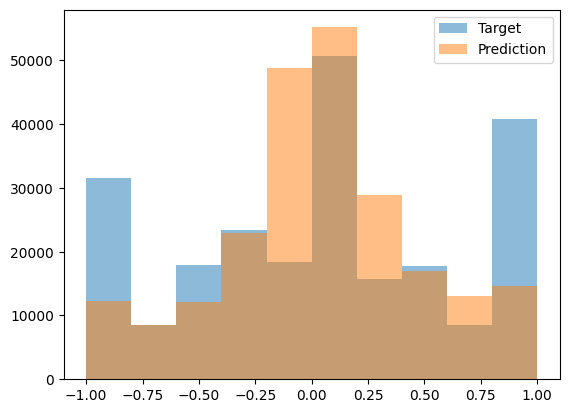

In [8]:
plt.hist(oof['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [22]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [23]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )

    # Create CatBoost Pool for test data
    test_pool = cb.Pool(
        data=test_processed[numerical_cols + categorical_cols],
        cat_features=categorical_cols
    )

    # Average predictions from all models
    predictions = np.mean([
        model.predict(test_pool)
        for model in trained_models
    ], axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [ ]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

In [ ]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [26]:
# Save all artifacts needed for prediction
catboost_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'encoder': encoder, 
    'scaler': scaler
}

with open('./catboost_predict.pkl', 'wb') as f:
    pickle.dump(catboost_predict, f)

***
